In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.simplefilter("ignore")

# Projet 5 : BottleNeck

## I. Contexte

BottleNeck est un marchand de vin prestigieux. L'entreprise dispose d'un ERP pour la gestion des ressources et des clients. 
Cependant, celui-ci n'est pas relié au site de vente en ligne, ce qui entraine:
1. une gestion des stocks complexe 
2. une visibilité en termes d’analyse des ventes sur le Net réduite.

L'objectif de ce projet est de rapprocher les données de l'erp à celles du site de vente en ligne afin de simplifier la gestion des stocks et ainsi, améliorer la visibilité sur l'analyse des ventes internet.

Travail à faire :
1. Rapprocher les données erp et web.
2. Calculer le chiffre d'affaire et analyser les ventes.
3. Analyser la variable prix et ses valeurs aberrantes.

## II. Rapprochement des données

Dans une base de données relationnelle il existe deux concepts importants : la clé primaire et la clé secondaire. 
1. La clé primaire est l'élément qui permet d'identifier de manière unique un enregistrement dans une table.
2. La clé sécondaire permet d'identifier une colonne ou un ensemble de colonnes d'une table comme référençant une colonne ou un ensemble de colonnes d'une autre table (la table référencée).

L'ensemble constitué d'une clé primaire et d'une clé étrangère sert à établir des relations entre tables.

Exemple : soit une table x et une table y ayant en commun certaines variables. Pour trouver les correspodances de la tale x sur y, on placera la clé primaire de x sur la tale y qui deviendra une clé secondaire sur la table y.

Selon le modèle relationnel et la 1FN, une clé primaire ne contient que des valeurs atomiques. Nous savons donc à l'avance qu'il va falloir analyser les clés candidates afin de s'assurer qu'elles soient des clés primaires appropriées (unique, pas de de NaN, ni de Null...).

Il serait donc judicieux de créer des fonctions afin d'automatiser ces tâches répétitives...

### 1. Préparation des fontions

In [2]:
# On définit une fonction qui check les doublons dans une colonne et indique le nombre de doublons contenus dans cette colonne suivi d'un aperçu de ces doulons.

def check_duplicates(data, column):
    n = len(data.index)
    if len(data[column].drop_duplicates()) == n :
        print ("La colonne", column, "ne contient pas de doublons")
    else :
        print("La colonne", column, "contient ", len(data[data[column].duplicated()]), " doublons.")
        return data[data[column].duplicated()]


In [3]:
# On définit une fonction qui check les valeurs manquantes et indique le nombre de valeurs manquantes contenues dans cette colonne suivi d'un aperçu de ces valeurs manquantes.
def check_nan(data, column):
    if len(data[data[column].isnull()]) == 0:
        print ("La colonne", column, "ne contient aucune valeur manquante")
    else :
        print("La colonne", column, "contient ", len(data[data[column].isnull()]), " valeurs manquantes.")
        return data[data[column].isnull()]

### 2. Préparation du fichier erp

In [4]:
erp = pd.read_excel("erp.xlsx")

In [5]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


#### 2.1. Analyse du dataframe

In [6]:
erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


Le dataframe chargé contient les variables suivantes :

1. "product_id" : c'est la clé primaire potentielle de la table (information confirmée avec la table de liaison). Cette colonne compte 825 valeurs non-null sur 825 lignes au total. Il n y aura donc pas de valeur manquante (Nan) sur "product_id" ...
2. "onsale_web" : indique les produits en vente sur le site web (1 si le produi est en vente en ligne | 0 s'il ne l'est pas)
3. "price" : indique le prix unitaire des produits.
4. "stock_quantity" :  quantité restante en stock
5. "stock_status : status du stock ( outofstock signifie rupture de stock | instock signifie en stock)

NB : notre étude concerne les produits en vente sur le site web. La colonne onsale_web précise justement si le produit est en vente en ligne ou non. 

#### 2.2. Analyse de la clé primaire

In [7]:
# On lance la fonction check_duplicates définie en amont avec les arguments erp et "product_id" afin de vérifier les doublons sur la clé potentielle.
check_duplicates(erp, "product_id")

La colonne product_id ne contient pas de doublons


In [8]:
# On lance la fonction check_nan définie en amont afin de vérifier les valeurs manquantes sur la clé potentielle.
check_nan(erp, "product_id")

La colonne product_id ne contient aucune valeur manquante


#### 2.3. Conclusion

erp est chargé avec 825 lignes et 5 colonnes. 

La clé candidate contient uniquement des valeurs atomiques, elle est donc approprié pour être la clé primaire.

Le dataframe est prêt pour la fusion.

### 3. Préparation du fichier web

In [9]:
web = pd.read_excel("web.xlsx")
web.rename(columns={"sku":"id_web"}, inplace=True)
pd.set_option('display.max_columns', None)
web.head()

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


#### 3.1. Analyse du dataframe

In [10]:
web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_web                 1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

web est chargé avec 1513 lignes et 28 variables. Chaque ligne représente un produit.

La colonne id_web est la clé primaire potentielle (voir la table de liaison). Cette colonne présente 1428 entrées non-null sur 1513 lignes. il aura donc des valeurs manquantes ...

La colonne total_sales donne le nombre de vente de chaque produit.

#### 3.2. Analyse de la clé primaire

In [11]:
# Nous commencerons par vérifier les doublons sur notre clé potentielle
check_duplicates(web, "id_web")

La colonne id_web contient  798  doublons.


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,NaN,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,NaN,publish,closed,closed,NaN,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,NaN,Camin Larredya Jurançon Sec La Virada 2018,NaN,publish,closed,closed,NaN,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,NaN,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,NaN,publish,closed,closed,NaN,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,NaN,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,NaN,publish,closed,closed,NaN,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [12]:
check_nan(web, "id_web")

La colonne id_web contient  85  valeurs manquantes.


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


"id_web" qui est la clé candidate contient 798 doublons et 85 valeurs manquantes. Cette clé viole la 1FN car les valeurs qu'elle contient ne sont pas atomiques.

En jetant un oeil sur les aperçus générés par les fonctions check_duplicates et check_nan, on remarque :
- quand la clé candidate est une valeur manquante, l'ensemble des colonnes affiche des NaN. Il n'y a donc aucune donnée à exploiter à ce niveau.
- Parmi les doublons, on retoruve les NaN(même orthographe donc doublon).
- "post_type" est une variable qualitative nominale à trois modalités.

Les modalités de la variable "post_type" :
1. NaN : indique les valeurs manquantes, 
2. attachement : indique les doublons
3. product : indique les données produits (par déduction ).

In [13]:
# En considérant uniquement les produits, on aura : 
web2 = web[web["post_type"] == "product"]

Analysons la clé potentielle avec cette nouvelle perspective.

In [14]:
check_duplicates(web2, "id_web")

La colonne id_web contient  1  doublons.


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,NaN,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,NaN,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [15]:
check_nan(web2, "id_web")

La colonne id_web contient  2  valeurs manquantes.


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,NaN,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,NaN,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,NaN,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,NaN,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Nous avons deux produits qui n'ont pas de clé primaire donc des NaN à la place. Ce qui entraine la présence d'un doublons dans les résultats de nos tests.

In [16]:
# On observe les données qui n'ont pas de clé primaire 
web_nopk = web2[web2["id_web"].isnull()]
web_nopk

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,NaN,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,NaN,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,NaN,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,NaN,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Nous avons deux produits qui n'ont pas de clé primaire. Il s'agit de :  
1. "Pierre Jean Villa Côte Rôtie Fongeant 2017"
2. "Pierre Jean Villa Condrieu Jardin Suspendu 2018". 

Nous allons devoir les écarter de l'analyse. Il est important de noter que cette action n'aura aucun effet majeur sur l'analyse (ni sur les stocks, ni sur les ventes internet) car il n'y a aucun enregistrement de vente concernant ces deux produits.

In [17]:
# On supprime les données sans clé primaire
web_final = web2.dropna(subset=["id_web"])

In [18]:
web_final

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,16135,0,0,0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,NaN,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,publish,closed,closed,NaN,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
767,15891,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,NaN,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,publish,closed,closed,NaN,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
768,15887,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,NaN,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",publish,closed,closed,NaN,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
797,13127-1,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,NaN,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",publish,closed,closed,NaN,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [19]:
# Vérification du dataframe final
check_duplicates(web_final, "id_web")
check_nan(web_final, "id_web")


La colonne id_web ne contient pas de doublons
La colonne id_web ne contient aucune valeur manquante


In [20]:
web_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 798
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_web                 714 non-null    object        
 1   virtual                714 non-null    int64         
 2   downloadable           714 non-null    int64         
 3   rating_count           714 non-null    int64         
 4   average_rating         714 non-null    float64       
 5   total_sales            714 non-null    float64       
 6   tax_status             714 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            714 non-null    float64       
 9   post_date              714 non-null    datetime64[ns]
 10  post_date_gmt          714 non-null    datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             714 non-null    object        
 13  post_

#### 3.3. Conclusion

797 doublons et valeurs manquantes ont été écratées de l'analyse.

Deux produits sans clé primaire ont été écartées de l'analyse.

web_final contient 714 entrées et 28 colonnes. 

La clé candidate est finalement composée uniquement des valeurs atomiques, elle est donc appropriée pour être la clé primaire.

Le dataframe est prêt pour la fusion.

### 4. Préparation de la table de liaison

In [21]:
liaison = pd.read_excel("liaison.xlsx")

In [22]:
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


#### 4.1. Analyse de la table

In [23]:
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


Nous avons 825 entrées pour "product_id" et 734 pour "id_web"

#### 4.2. Analyse des clés

In [24]:
check_duplicates(liaison, "product_id")
check_nan(liaison, "product_id")

La colonne product_id ne contient pas de doublons
La colonne product_id ne contient aucune valeur manquante


In [25]:
check_duplicates(liaison, "id_web")
check_nan(liaison, "id_web")

La colonne id_web contient  90  doublons.
La colonne id_web contient  91  valeurs manquantes.


,product_id,id_web
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
817,7196,NaN
818,7200,NaN
819,7201,NaN
820,7203,NaN


#### 4.3. Conclusion

La table liaison contient 825 entrées, exactement comme le fichier erp, ce qui explique pourquoi la colonne product_id (correspondance de la clé primaire du fichier erp) ne contienne ni doublons, ni de valeurs manquantes.

Cependant, il y a 91 produits qui n'auront pas de correspondances sur le site web.

### 5. La fusion

La fuqion va se passer en deux étapes :
1. On fusionne erp avec la table de liaison.
2. On rajoute web_final au dataframe résultant de la première fusion.

#### 5.1. Fusion : erp + liaison

In [26]:
erp_liaison = pd.merge(erp, liaison, on="product_id", how="outer", indicator=True)

In [27]:
erp_liaison.head()

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,3847,1,24.2,0,outofstock,15298,both
1,3849,1,34.3,0,outofstock,15296,both
2,3850,1,20.8,0,outofstock,15300,both
3,4032,1,14.1,0,outofstock,19814,both
4,4039,1,46.0,0,outofstock,19815,both


In [28]:
# On check si toutes les lignes sont recupérées
len(erp_liaison[erp_liaison['_merge']!='both'])

0

In [29]:
erp_liaison.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   product_id      825 non-null    int64   
 1   onsale_web      825 non-null    int64   
 2   price           825 non-null    float64 
 3   stock_quantity  825 non-null    int64   
 4   stock_status    825 non-null    object  
 5   id_web          734 non-null    object  
 6   _merge          825 non-null    category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 46.1+ KB


Suite à la fusion, chacune des lignes de erp a trouvé sa correspondance sur liasion.

#### 5.2. Fusion : erp + liaison + web

In [30]:
erp_liaison= erp_liaison.drop(columns="_merge")

In [31]:
erp_web = pd.merge(erp_liaison, web_final, on="id_web",  how="outer", indicator=True)

In [32]:
erp_web.head()

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,_merge
0,3847,1,24.2,0,outofstock,15298,0.0,0.0,0.0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
1,3849,1,34.3,0,outofstock,15296,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
2,3850,1,20.8,0,outofstock,15300,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
3,4032,1,14.1,0,outofstock,19814,0.0,0.0,0.0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
4,4039,1,46.0,0,outofstock,19815,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-12 09:04:37,2018-02-12 08:04:37,NaN,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,publish,closed,closed,NaN,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both


In [33]:
len(erp_web[erp_web['_merge']=='right_only'])

0

In [34]:
len(erp_web[erp_web['_merge']=='left_only'])

111

111 produits de l'erp n'ont pas de correspondances sur le web

In [35]:
erp_web.describe()

,product_id,onsale_web,price,stock_quantity,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,825.000000,825.000000,825.000000,825.000000,714.0,714.0,714.0,714.0,714.000000,0.0,714.000000,0.0,0.0,0.0,714.0,714.0,714.0
mean,5162.597576,0.869091,32.415636,26.496970,0.0,0.0,0.0,0.0,4.012605,NaN,1.998599,NaN,NaN,NaN,0.0,0.0,0.0
std,902.644635,0.337506,26.795849,45.892422,0.0,0.0,0.0,0.0,8.518183,NaN,0.037424,NaN,NaN,NaN,0.0,0.0,0.0
min,3847.000000,0.000000,5.200000,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,4348.000000,1.000000,14.600000,1.000000,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,4907.000000,1.000000,24.400000,11.000000,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,5805.000000,1.000000,42.000000,34.000000,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,7338.000000,1.000000,225.000000,578.000000,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


In [36]:
# On observe les données sans correspondances ..
data_no_correspondaces = erp_web[erp_web['_merge']!='both']
data_no_correspondaces

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,_merge
19,4055,0,86.1,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
20,4090,0,73.0,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
21,4092,0,47.0,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22,4195,0,14.1,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,4209,0,73.5,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,5954,0,18.8,0,outofstock,15609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
718,5955,0,27.3,0,outofstock,14377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
720,5957,0,39.0,0,outofstock,13577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
743,6100,0,12.9,0,outofstock,15529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [37]:
# On check la variale post_type
data_no_correspondaces[data_no_correspondaces["post_type"].notnull()]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,_merge


Data_no_correspondaces ne contient pas de données à exploiter. Nous pouvons l'écarter de l'analyse.

In [38]:
# En considérant uniquement les données qui sont sur les deux tables on aura:
erp_web_final = erp_web[erp_web['_merge'] =='both']
# c'est l'équivalent d'un innerjoin au final...

In [39]:
erp_web_final

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,_merge
0,3847,1,24.2,0,outofstock,15298,0.0,0.0,0.0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
1,3849,1,34.3,0,outofstock,15296,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
2,3850,1,20.8,0,outofstock,15300,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
3,4032,1,14.1,0,outofstock,19814,0.0,0.0,0.0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
4,4039,1,46.0,0,outofstock,19815,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2018-02-12 09:04:37,2018-02-12 08:04:37,NaN,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,publish,closed,closed,NaN,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,6930,1,8.4,83,instock,16135,0.0,0.0,0.0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,NaN,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,publish,closed,closed,NaN,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
820,7023,1,27.5,15,instock,15891,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,NaN,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,publish,closed,closed,NaN,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
821,7025,1,69.0,2,instock,15887,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,NaN,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",publish,closed,closed,NaN,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
822,7247,1,54.8,23,instock,13127-1,0.0,0.0,0.0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,NaN,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",publish,closed,closed,NaN,clos-du-mont-

Nous nous assurons une dernière fois que nos clés sont appropriées...

In [40]:
check_duplicates(erp_web_final, "product_id")
check_nan(erp_web_final, "product_id")

La colonne product_id ne contient pas de doublons
La colonne product_id ne contient aucune valeur manquante


In [41]:
check_duplicates(erp_web_final, "id_web")
check_nan(erp_web_final, "id_web")

La colonne id_web ne contient pas de doublons
La colonne id_web ne contient aucune valeur manquante


## III. Chiffre d'affaire

In [42]:
ca = erp_web_final[["product_id", "post_title", "price", "total_sales"]].copy()

Pour calculer le chiffre d'affaire, on aura besoin des colonnes "price" et "total_sales". Il est important de s'assurer que ces colonnes sont composées de valeurs numériques avant de procéder au calcul.

In [43]:
ca.dtypes

product_id       int64
post_title      object
price          float64
total_sales    float64
dtype: object

### 1. Calcul du C.A.

In [44]:
ca["chiffre d'affaire"] = ca["price"] * ca["total_sales"]

In [45]:
ca_total = ca["chiffre d'affaire"].sum()

In [46]:
print("Le chiffre d'affaire est :", ca["chiffre d'affaire"].sum())

Le chiffre d'affaire est : 70568.6


In [47]:
ca.describe()

,product_id,price,total_sales,chiffre d'affaire
count,714.000000,714.000000,714.000000,714.000000
mean,5032.557423,32.493137,4.012605,98.835574
std,790.510878,27.810525,8.518183,307.685071
min,3847.000000,5.200000,0.000000,0.000000
25%,4280.250000,14.100000,0.000000,0.000000
50%,4796.000000,23.550000,1.000000,15.250000
75%,5710.500000,42.175000,4.000000,91.150000
max,7338.000000,225.000000,96.000000,4704.000000


Nous avons 714 articles.

L'article le plus cher est à : 225 et le moins cher à 5.20

Le prix moyen des articles est de 32.50

Le plus gros chiffre réalisé pour un article est : 4704

Le nombre de ventes le plus important pour un article est : 96


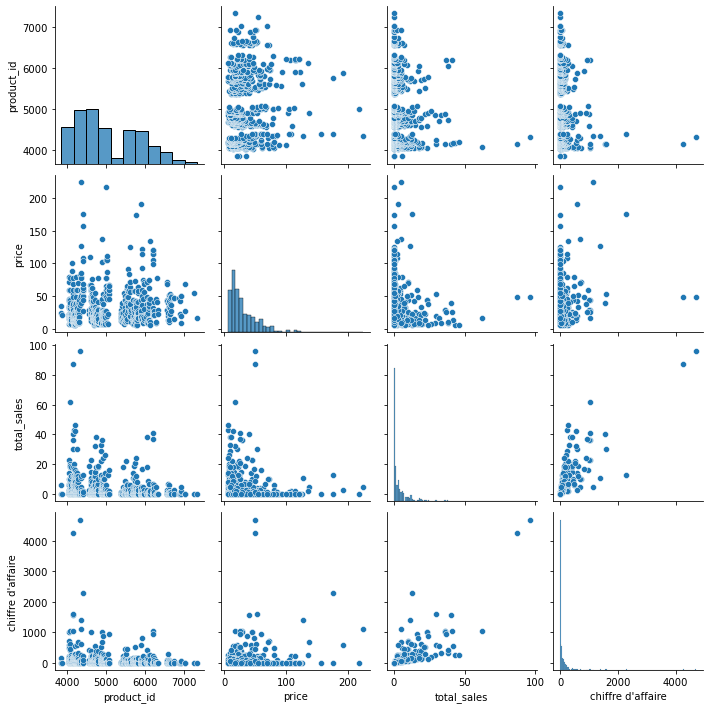

In [48]:
sns.pairplot(ca)

- price / product_id : on observe une forte densité en dessous de 100 au niveau du prix, le même grahique donne un aperçu des valeurs aberrantes.
- total_sales / price :  les produits à moins de 100 sont les plus vendus.
- chiffre d'affaire / price => les produits autour de 50 sont les plus achetés.
- total_sales / chiffre d'affaire : 2 produits ont enregistrés un important pic de ventes.

### 2. Bonus : Top C.A. par produit

In [49]:
# On crée un nouveau dataframe et on calcul le C.A. par produit dans une nouvelle colonne de ce df.
top_ca = ca.sort_values(by="chiffre d'affaire", ascending=False)
top_ca["proportion sur le C.A. total (en %)"] = round((top_ca["chiffre d'affaire"]/ca_total)*100, 2)
top_ca.head(10)

,product_id,post_title,price,total_sales,chiffre d'affaire,proportion sur le C.A. total (en %)
286,4334,Champagne Gosset Grand Blanc de Blancs,49.0,96.0,4704.0,6.67
162,4144,Champagne Gosset Grand Rosé,49.0,87.0,4263.0,6.04
310,4402,Cognac Frapin VIP XO,176.0,13.0,2288.0,3.24
161,4142,Champagne Gosset Grand Millésime 2006,53.0,30.0,1590.0,2.25
160,4141,Champagne Gosset Grande Réserve,39.0,40.0,1560.0,2.21
293,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5,1.97
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0,1.59
170,4153,Elian Daros Côtes du Marmandais Clos Baquey 2015,29.0,36.0,1044.0,1.48
761,6206,Domaine Giudicelli Patrimonio Blanc 2019,25.2,41.0,1033.2,1.46
121,4068,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,62.0,1029.2,1.46


### 3. Bonus : Top ventes par produit

In [50]:
top_ventes = ca.sort_values(by="total_sales", ascending=False)
top_ventes.head(10)

,product_id,post_title,price,total_sales,chiffre d'affaire
286,4334,Champagne Gosset Grand Blanc de Blancs,49.0,96.0,4704.0
162,4144,Champagne Gosset Grand Rosé,49.0,87.0,4263.0
121,4068,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,62.0,1029.2
210,4200,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,5.8,46.0,266.8
188,4172,Maurel Pays d'Oc Chardonnay 2019,5.7,43.0,245.1
200,4187,Le Pas de l'Escalette Languedoc Les Petits Pas...,13.3,42.0,558.6
761,6206,Domaine Giudicelli Patrimonio Blanc 2019,25.2,41.0,1033.2
160,4141,Champagne Gosset Grande Réserve,39.0,40.0,1560.0
734,6047,Château de La Liquière Faugères L'Ampoule 2019,10.9,38.0,414.2
418,4729,Emile Boeckel Crémant Brut Blanc de Blancs,8.6,38.0,326.8


Les prix des 10 articles qui ont enregistré le plus de ventes varient entre 5 et 49 euros en fonction du type d'article (les champagnes, vin rouge, etc...). 

### 4. Bonus : C.A. des deux produits phares

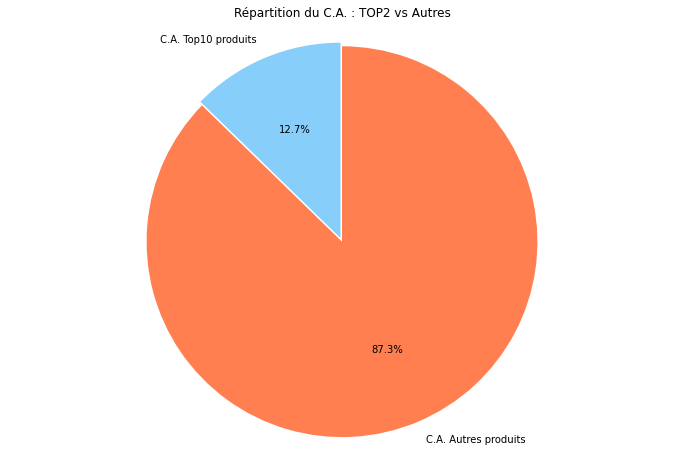

In [51]:
# On recupère top_ca converti en tableau numpy dans une variable.
graph = top_ca.to_numpy()

# On crée une liste vide
top2 = []

# On rajoute la somme des 2 premières lignes de la dernière colonne du tableau
top2.append(round(sum(graph[:2,-1].tolist()),2))

# On rajoute la somme de la 10e à la dernière ligne de la dernière colonne du tableau
top2.append(round(sum(graph[2:,-1].tolist()),2))

# On plot
plt.figure(figsize=(12,8))
plt.title("Répartition du C.A. : TOP2 vs Autres")
labels = " C.A. Top10 produits", "C.A. Autres produits"
colors = ['lightskyblue','coral' ]
explode = [0.02,0]
plt.pie(x=top2, colors=colors,labels=labels, explode =explode ,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.savefig('PieChart01.png')

Les deux produits les plus vendus ont réalisé presque 13% du chiffre d'affaire. Il s'agit de :
1. Champagne Gosset Grand Blanc de Blancs
2. Champagne Gosset Grand Rosé

## IV. Les valeurs aberrantes

En statistique, un outlier est une valeur ou une observation qui est « distante » des autres observations effectuées sur le même phénomène, c'est-à-dire qu'elle contraste grandement avec les valeurs « normalement » mesurées.
Cependant, un outlier n'est pas forcément une valeur fausse ! Même si elle est disproportionnée par rapport aux autres valeurs de la variable et que c'est difficile à concevoir, c'est quand même possible.

Quand un outlier est une valeur fausse on l'appelle valeur aberrante, sinon c'est valeur atypique.
Il existe plusieurs méthode qui permettent de detecter les outliers : le zscore, l'écart interquartille, etc...

Un z-score est le nombre d’écarts types par rapport à la moyenne d’un point d’information. Quoi qu’il en soit, il s’agit en fait d’une proportion du nombre d’écarts-types en dessous ou au-dessus de la population que représente un score brut. Cette méthode présente un avantage : celui de définir le seuil  de comparaison.
Nous allons retenir cette méthode pour la suite de l'analyse.

### 1. Détection des outliers

In [52]:
# On copie le dataframe ca
outlier = ca.copy()

# On calcule le zscore sur les prix des article dans la colonne zscore-price
outlier["zscore_price"] = round((outlier["price"] - outlier["price"].mean())/outlier["price"].std(),2)

# En considérant le seuil standard qui est : -2 à 2, on aura :
price_outlier = outlier.loc[(outlier["zscore_price"] <= -2) | (outlier["zscore_price"] >= 2), ["product_id", "post_title", "price", "zscore_price"]].sort_values(by="zscore_price", ascending=False)
price_outlier

,product_id,post_title,price,zscore_price
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,6.92
525,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5,6.65
692,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,5.71
310,4402,Cognac Frapin VIP XO,176.0,5.16
657,5767,Camille Giroud Clos de Vougeot 2016,175.0,5.12
313,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,4.48
478,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,3.76
752,6126,Champagne Gosset Célébris Vintage 2007,135.0,3.69
293,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,3.38
615,5612,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,3.32


In [53]:
print("On observe", len(price_outlier["price"]), "outliers affichés dans le dataframe ci-dessus")

On observe 30 outliers affichés dans le dataframe ci-dessus


### 2. Bonus : Analyse des valeurs outliers les plus extrêmes ( prix > 150 )

In [54]:
focus_outliers = price_outlier.loc[price_outlier["price"] > 150,["product_id","post_title","price"]].copy()
liste_price = focus_outliers ["price"].tolist()
focus_outliers["rival_price (source : internet)"] = focus_outliers ["price"]
focus_outliers["rival_price (source : internet)"].replace(liste_price,[900.0, 229.0, 189.0, 153.0, 189.0,145.0], inplace=True)
focus_outliers["proportion prix /prix du marché (en %)"] = round((focus_outliers ["price"] / focus_outliers["rival_price (source : internet)"])*100,2)
focus_outliers

,product_id,post_title,price,rival_price (source : internet),proportion prix /prix du marché (en %)
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,900.0,25.00
525,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5,229.0,94.98
692,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,189.0,101.22
310,4402,Cognac Frapin VIP XO,176.0,153.0,115.03
657,5767,Camille Giroud Clos de Vougeot 2016,175.0,189.0,92.59
313,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,145.0,108.28


Nous avons selectionné les articles les plus chers et comparé leurs prix à ceux prtatiqués par la concurrence. Majoritairement, ces prix se rapprochent à ceux de la concurrence à plus ou moins 10% de difference.

Champagne Egly-Ouriet Grand Cru Millésimé 2008 est un produit haut de gamme qui existe en quantité très limitée sur le marché aujourd'hui, ce qui a entrainé une augmentation de la valeur de ce dernier équivalent à 4 fois son prix.

In [55]:
# On check les ventes réalisées sur cet article
perte = top_ca.loc[top_ca["post_title"]=="Champagne Egly-Ouriet Grand Cru Millésimé 2008", ["product_id","post_title","price","total_sales","chiffre d'affaire"]]

# On calcul le ca potentiellement perdu
perte["rival_price (source : internet)"] = 900.0
perte["ca_rival_price"] = perte["total_sales"] * perte["rival_price (source : internet)"]
perte["ca_perdu"] = perte["ca_rival_price"] - perte["chiffre d'affaire"]
perte

,product_id,post_title,price,total_sales,chiffre d'affaire,rival_price (source : internet),ca_rival_price,ca_perdu
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0,900.0,4500.0,3375.0


In [56]:
print("Pratiquer les mêmes prix que la concurrence sur ce produit aurait pû faire monter le chiffre d'affaire total de ",round((perte["ca_perdu"].sum() / ca_total)*100,2),"%.")

Pratiquer les mêmes prix que la concurrence sur ce produit aurait pû faire monter le chiffre d'affaire total de  4.78 %.


### 3. Représentation graphique des outliers

#### 3.1 Boite à moustache ou Boxplot

<AxesSubplot:>

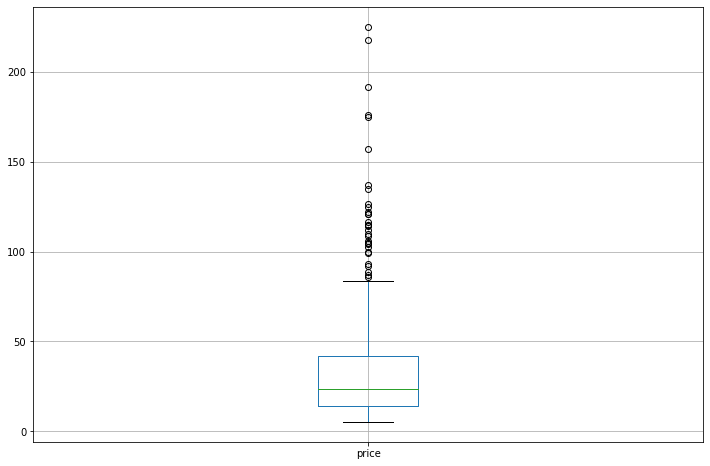

In [57]:
# On applique boxplot sur la colonne "price"
ca.boxplot(column=['price'], figsize=(12,8))  

Ce graphique affiche directement les valeurs qui s'ecartent de la moyenne. Dans notre le max se situe aux alentours de 90. 
La plus petite valeur dans la liste des outliers est de 88.4; ce qui confirme notre analyse.

#### 3.2. Nuage de points ou Scatter

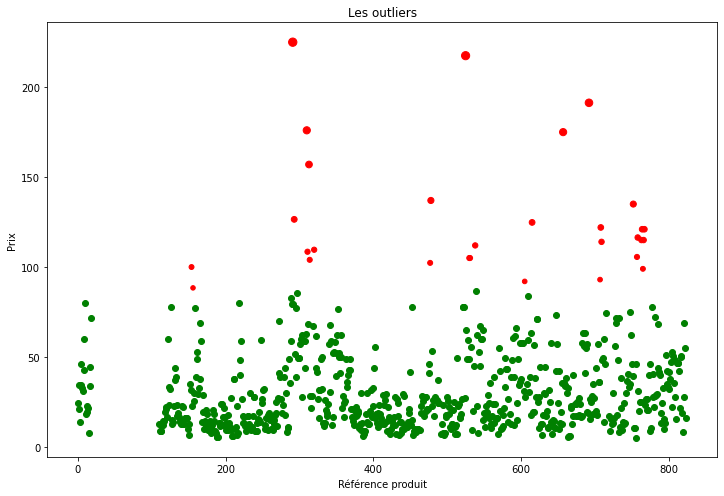

In [58]:
# On recupère les valeur aberrantes dans une variable
the_outliers = outlier[(outlier["zscore_price"] >= 2) | (outlier["zscore_price"] <= -2)]

# On recupère les valeurs non aberrantes dans une autre variable
the_ok = outlier[(outlier["zscore_price"] < -2) | (outlier["zscore_price"] < 2)]

# On plot
plt.figure(figsize=(12,8))
plt.title("Les outliers")

# On place les points des valeurs aberrantes sur le graphique
plt.scatter(the_ok['price'].index, the_ok['price'].values, c="green")

# On place les points des valeurs aberrantes dans une autre couleur sur le graphique
plt.scatter(the_outliers['price'].index, the_outliers['price'].values,c="red", s= the_outliers["zscore_price"]  * 10)

plt.xlabel("Référence produit")
plt.ylabel("Prix")
plt.savefig('ScatterPlot_outliers.png')


## V. Conclusion 

Le rapprochement des données erp et web s'est réalisé avec succès après un travail sur la conformité des clés primaires. 
Nous avons réussi à recupérer l'ensemble des données en provenance de l'erp soit 825 produits.
Quant aux données du fichier web, nous avons gardé 714 produits et mis de coté 2 produits sans clés primaires et 797 doublons.

Une fois les données rapprochées, nous avons calculé le chiffre d'affaire qui est égal à  70568.6. Les deux produits qui ont enregistré les plus gros chiffres d'affaire représentent presque 13% du chiffre d'affaire total.

Nous avons relevé 30 valeurs aberrantes avec la méthode zscore. Nous avons ensuite comparé le prix des articles concercerné aux prix de la concurrence. certains prix ont évolué notament celui du Champagne Egly-Ouriet Grand Cru Millésimé 2008 qui vaut 4 fois plus cher aujourd'hui.

Il sera important de :
- Remonter à l'équipe technique les deux produits qui n'ont pas été pris en compte dans l'analyse par manque de clé primaire. Il s'agit de : "Pierre Jean Villa Côte Rôtie Fongeant 2017" et
"Pierre Jean Villa Condrieu Jardin Suspendu 2018".

- Remonter à l'équipe marketing la liste des outliers avec une note spéciale sur l'augmentation de la valeur du produit Champagne Egly-Ouriet Grand Cru Millésimé 2008.